In [2]:
import cv2
import numpy as np
from PIL import Image
from skimage import feature as ft

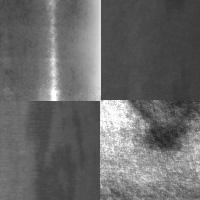

In [16]:
img = Image.open('data/images/testB3/000023.jpg')
img

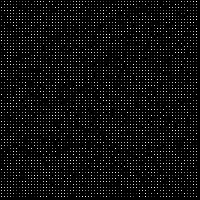

In [17]:
def HOG(img):
    # 将图像转换为NumPy数组并转换为灰度
    r_img = np.array(img)
    gray_image = cv2.cvtColor(r_img, cv2.COLOR_BGR2GRAY)
    
    # 提取HOG特征并可视化
    features, hog_image = ft.hog(
        gray_image,
        orientations=6,
        pixels_per_cell=(3, 3),
        cells_per_block=(2, 2),
        visualize=True
    )
    
    # 返回HOG特征和可视化图像
    hog_image = Image.fromarray((hog_image * 255).astype(np.uint8))
    return features, hog_image
fea, hog_img = HOG(img)
hog_img

In [2]:
import torch 
from torch import nn
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Conv2d(in_channels, in_channels // reduction, kernel_size=1)
        self.fc2 = nn.Conv2d(in_channels // reduction, in_channels, kernel_size=1)
        
    def forward(self, x):
        se_weight = torch.mean(x, dim=(2, 3), keepdim=True)
        se_weight = torch.relu(self.fc1(se_weight))
        se_weight = torch.sigmoid(self.fc2(se_weight))
        return x * se_weight

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7, out_channels=1):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, out_channels, kernel_size, padding=kernel_size // 2)
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = torch.sigmoid(self.conv(x))
        return x * x

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7, out_channels=1):
        super(CBAM, self).__init__()
        self.channel_attention = SEBlock(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size, out_channels)
    
    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

In [5]:
net = CBAM(128, reduction=2, out_channels=128)
# 计算参数量
print(sum(p.numel() for p in net.parameters()))
x = torch.randn(32, 128, 200, 200)
net(x).shape

29248


torch.Size([32, 128, 200, 200])

In [53]:
import cv2
import numpy as np
from PIL import Image
from skimage import feature as ft
def check(img, thr_low=0.0275, thr_high=0.4, high=8.8, low=0.432):
    gray_img = np.array(img.convert("L"))

    # 计算极端像素的比例（假设0和255表示椒盐噪声）
    num_pixels = gray_img.size
    salt_count = np.sum(gray_img == 255)
    pepper_count = np.sum(gray_img == 0)
    salt_pepper_count = salt_count + pepper_count
    noise_ratio = salt_pepper_count / num_pixels
    return (noise_ratio > thr_low) and (noise_ratio < thr_high) and (salt_count / pepper_count < high) and (salt_count / pepper_count > low)

def count_salt(img):
    gray_img = np.array(img.convert("L"))
    salt_count = np.sum(gray_img == 255)
    return salt_count

def count_pepper(img):
    gray_img = np.array(img.convert("L"))
    pepper_count = np.sum(gray_img == 0)
    return pepper_count

In [63]:
# testB 上评估椒盐检测算法
import pandas as pd
import os
data = pd.DataFrame({'id': os.listdir('data/images/testB3')})
data['id'] = data['id'].apply(lambda x: x.split('.')[0])
data['path'] = data['id'].apply(lambda x: f'data/images/testB3/{x}.jpg')
# 604~1432
data['label'] = data['id'].apply(lambda x: 1 if 604 <= int(x) <= 1432 else 0)
data['pred'] = data['path'].apply(lambda x: check(Image.open(x), thr_low=0.0275, thr_high=0.21, high=8.8, low=0.432))
data[data['pred'] == True]['label'].value_counts()

/tmp/ipykernel_9217/3594396897.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return (noise_ratio > thr_low) and (noise_ratio < thr_high) and (salt_count / pepper_count < high) and (salt_count / pepper_count > low)


label
1    150
0      2
Name: count, dtype: int64

In [68]:
# 生成数据集上评估椒盐检测算法
import pandas as pd
import os
data = pd.read_csv('stats/train-meta.csv', dtype=str)
data['path'] = data['id'].apply(lambda x: f'data/images/training/{x}.jpg')
data['label'] = data['id'].str.startswith('3')
data['pred'] = data['path'].apply(lambda x: check(Image.open(x), thr_low=0.038, thr_high=0.21, high=8.8, low=0.432))
data[data['pred'] == True]['label'].value_counts()

/tmp/ipykernel_9217/3594396897.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return (noise_ratio > thr_low) and (noise_ratio < thr_high) and (salt_count / pepper_count < high) and (salt_count / pepper_count > low)


label
True     4328
False      14
Name: count, dtype: int64

In [36]:
data[data['label'] == True]['salt'] / data[data['label'] == True]['pepper']

13410     2.822695
13411     2.238636
13412     3.187354
13413     3.774566
13414     8.155914
           ...    
17875     1.400000
17876     5.428571
17877    12.764706
17878     7.756098
17879     0.211849
Length: 4470, dtype: float64

In [27]:
data['pred'] = data['path'].apply(lambda x: check(Image.open(x), thr=0.039,high=8.8, low=0.432))
data[data['pred'] == True]['label'].value_counts()

/tmp/ipykernel_9217/182302610.py:14: RuntimeWarning: divide by zero encountered in scalar divide
  return (noise_ratio > thr) and (salt_count / pepper_count < high) and (salt_count / pepper_count > low)


label
True     800
False     13
Name: count, dtype: int64

111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111
111


KeyboardInterrupt: 